In [82]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import time
import functools
import heapq
from scipy.ndimage import morphology as morph
import sys
from skimage.morphology import disk
from skimage.metrics import structural_similarity as ssim
from numba import jit

In [101]:
def getImg(path, flag):  #flag = 0 for greyscale images, 1 for coloured

    # Reads image from given file path and resizes it if needed(testing purposes)
    img=cv2.imread(path, flag)
    scale_percent = 100
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    for i in range(len(powers)):
        if width<=powers[i]:
            width=powers[i]
            break
            
    for i in range(len(powers)):
        if height<=powers[i]:
            height=powers[i]
            break
            
#     print(width,height)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    #Converts image from BGR to RGB format
    if flag == 1:
        b,g,r=cv2.split(img)
        img=cv2.merge([r,g,b])

    return img

def genDepthImage(imgL, imgR): #Takes two images in stereoscopic alignment to generate a depth image
    l=cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    r=cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=9)
    image = stereo.compute(l,r)

    return image

def downsample(img, scale_percent): #Downsamples an image based on the scaling factor
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    return img

def gaussian(sigma, x):
    #Returns the gaussian distribution at a location x for the given sigma
    # print("gauss got ", sigma, x)
    return float(math.exp(-(x/(2*(sigma**2)))))

def stepUp(img):
    #Converts an NxM image to an 2Nx2M image by adding alternating empty rows and columns to the image
    newimage = np.zeros((img.shape[0]*2, img.shape[1]*2))
    newimage[::2,::2] = img
    newimage = newimage.astype('uint8')
    return newimage

def genLambda(img):
    #Uses the dimensions of image to generate the lambda array needed during depth propagation
    arr = np.ones(img.shape)
    arr = stepUp(arr)
    return arr

def genGuidanceImg(grey, depth): # generates downsampled grey scale image using rgb original image using 
                                # dimensions of intermediate depth image

    # grey = cv2.cvtColor(np.copy(rgb), cv2.COLOR_RGB2GRAY)
    grey = downsample(grey, (depth.shape[0]/grey.shape[0])*100)
    ans = np.copy(grey)
    ans[0] = (grey[0] - np.min(grey[0]))/(np.max(grey[0])-np.min(grey[0]))
    ans[1] = (grey[1] - np.min(grey[1]))/(np.max(grey[1])-np.min(grey[1]))
    ans[2] = (grey[2] - np.min(grey[2]))/(np.max(grey[2])-np.min(grey[2]))
    return ans

def dist(a, b):
    a = a.astype('int')
    b = b.astype('int')
    return (a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2

def propagate(depth, guidance, k, lam, sigS, sigR): # fills the empty pixels using the neighbour pixels  

    templam = np.copy(lam)
    depth = depth.astype('int')
#     fills in cells with four neighbours on the diagonals
    for i in range(1,depth.shape[0]-1, 2):
        for j in range(1, depth.shape[1]-1, 2): #iterating only over the required pixels in the first step
            # total is the average of pixel values of 4 neighbours
            total1 = int(depth[i-1][j-1]+depth[i+1][j-1]+depth[i-1][j+1]+depth[i+1][j+1])
            total1 /= 4
            # creating an array containing all the 4 neighbour pixel values and their average
            dx = [depth[i-1][j-1],depth[i+1][j-1],depth[i-1][j+1],depth[i+1][j+1], total1]
            val = sys.float_info.max
            for d in dx:
                final = 0.0
                # iterating over neighbourhood of filter size
                for p in range(i-math.floor(k/2), k+i-math.floor(k/2)):
                    for q in range(j-math.floor(k/2), k+j-math.floor(k/2)):
                        if p < 0 or q < 0 or p >= guidance.shape[0] or q >= guidance.shape[1]:
                            continue
                        elif lam[p][q] == 0:
                            continue
                        else:
                            euc = (((i-p)/depth.shape[0])**2)+((((j-q)/depth.shape[1])**2))
                            final += (gaussian(sigS, euc) * gaussian(sigR, dist(guidance[i][j], guidance[p][q])) * min(0.5, abs(d - int(depth[p][q]))))
                # taking the d with minimum cost value and assigning it to the empty pixel
                if final < val:
                    val = final
                    depth[i][j] = d
                    templam[i][j] = 1
    lam = np.copy(templam)
    
#     fills in cells with four neighbours along the edges
    for i in range(1,depth.shape[0]-2):
        for j in range(1, depth.shape[1]-2):
            if lam[i][j] == 1:
                continue
            total = depth[i][j-1]+depth[i][j+1]+depth[i-1][j]+depth[i+1][j]
            total /= 4
            dx = [depth[i][j-1], depth[i][j+1], depth[i-1][j], depth[i+1][j], total]
            val = sys.float_info.max
            for d in dx:
                final = 0.0
                # iterating over neighbourhood of filter size
                for p in range(i-math.floor(k/2), k+i-math.floor(k/2)):
                    for q in range(j-math.floor(k/2), k+j-math.floor(k/2)):
                        if p < 0 or q < 0 or p >= guidance.shape[0] or q >= guidance.shape[1]:
                            continue
                        elif lam[p][q] == 0:
                            continue
                        else:
                            euc = (((i-p)/depth.shape[0])**2)+((((j-q)/depth.shape[1])**2))
                            final += (gaussian(sigS, euc) * gaussian(sigR, dist(guidance[i][j], guidance[p][q])) * min(0.5, abs(d - int(depth[p][q]))))
                # taking the d with minimum cost value and assigning it to the empty pixel
                if final < val:
                    val = final
                    depth[i][j] = d
                    templam[i][j] = 1
    lam = np.copy(templam)
    
#     fills in cells on the leftmost column with three neighbours
    for i in range(1,depth.shape[0]-2):
        if lam[i][0] == 1:
                continue
        j=0
        total = depth[i][1]+depth[i-1][0]+depth[i+1][0]
        total /= 3
        dx = [depth[i][1], depth[i-1][0], depth[i+1][0], total]
        val = sys.float_info.max
        for d in dx:
                final = 0.0
                # iterating over neighbourhood of filter size
                for p in range(i-math.floor(k/2), k+i-math.floor(k/2)):
                    for q in range(j-math.floor(k/2), k+j-math.floor(k/2)):
                        if p < 0 or q < 0 or p >= guidance.shape[0] or q >= guidance.shape[1]:
                            continue
                        elif lam[p][q] == 0:
                            continue
                        else:
                            euc = (((i-p)/depth.shape[0])**2)+((((j-q)/depth.shape[1])**2))
                            final += (gaussian(sigS, euc) * gaussian(sigR, dist(guidance[i][j], guidance[p][q])) * min(0.5, abs(d - int(depth[p][q]))))
                # taking the d with minimum cost value and assigning it to the empty pixel
                if final < val:
                    val = final
                    depth[i][j] = d
                    templam[i][j] = 1
    lam = np.copy(templam)
    
#     fills in cells on the second rightmost column with three neighbours
    for i in range(1,depth.shape[0]-2):
        j=depth.shape[1]-2
        if lam[i][j] == 1:
            continue
        total = depth[i][j-1]+depth[i-1][j]+depth[i+1][j]
        total /= 3
        dx = [depth[i][j-1], depth[i-1][j], depth[i+1][j], total]
        val = sys.float_info.max
        for d in dx:
                final = 0.0
                # iterating over neighbourhood of filter size
                for p in range(i-math.floor(k/2), k+i-math.floor(k/2)):
                    for q in range(j-math.floor(k/2), k+j-math.floor(k/2)):
                        if p < 0 or q < 0 or p >= guidance.shape[0] or q >= guidance.shape[1]:
                            continue
                        elif lam[p][q] == 0:
                            continue
                        else:
                            euc = (((i-p)/depth.shape[0])**2)+((((j-q)/depth.shape[1])**2))
                            final += (gaussian(sigS, euc) * gaussian(sigR, dist(guidance[i][j], guidance[p][q])) * min(0.5, abs(d - int(depth[p][q]))))
                # taking the d with minimum cost value and assigning it to the empty pixel
                if final < val:
                    val = final
                    depth[i][j] = d
                    templam[i][j] = 1
    lam = np.copy(templam)
    
#     fills in cells on the topmost row with three neighbours    
    for j in range(1,depth.shape[1]-2):
        i=0
        if lam[i][j] == 1:
            continue
        total = depth[i+1][j]+depth[i][j-1]+depth[i][j+1]
        total /= 3
        dx = [depth[i+1][j], depth[i][j-1], depth[i][j+1], total]
        val = sys.float_info.max
        for d in dx:
                final = 0.0
                # iterating over neighbourhood of filter size
                for p in range(i-math.floor(k/2), k+i-math.floor(k/2)):
                    for q in range(j-math.floor(k/2), k+j-math.floor(k/2)):
                        if p < 0 or q < 0 or p >= guidance.shape[0] or q >= guidance.shape[1]:
                            continue
                        elif lam[p][q] == 0:
                            continue
                        else:
                            euc = (((i-p)/depth.shape[0])**2)+((((j-q)/depth.shape[1])**2))
                            final += (gaussian(sigS, euc) * gaussian(sigR, dist(guidance[i][j], guidance[p][q])) * min(0.5, abs(d - int(depth[p][q]))))
                # taking the d with minimum cost value and assigning it to the empty pixel
                if final < val:
                    val = final
                    depth[i][j] = d
                    templam[i][j] = 1
    lam = np.copy(templam)
    
#     fills in cells on the second bottommost row with three neighbours
    for j in range(1,depth.shape[1]-2):
        i=depth.shape[0]-2
        if lam[i][j] == 1:
            continue
        total = depth[i-1][j]+depth[i][j-1]+depth[i][j+1]
        total /= 3
        dx = [depth[i-1][j], depth[i][j-1], depth[i][j+1], total]
        val = sys.float_info.max
        for d in dx:
                final = 0.0
                # iterating over neighbourhood of filter size
                for p in range(i-math.floor(k/2), k+i-math.floor(k/2)):
                    for q in range(j-math.floor(k/2), k+j-math.floor(k/2)):
                        if p < 0 or q < 0 or p >= guidance.shape[0] or q >= guidance.shape[1]:
                            continue
                        elif lam[p][q] == 0:
                            continue
                        else:
                            euc = (((i-p)/depth.shape[0])**2)+((((j-q)/depth.shape[1])**2))
                            final += (gaussian(sigS, euc) * gaussian(sigR, dist(guidance[i][j], guidance[p][q])) * min(0.5, abs(d - int(depth[p][q]))))
                # taking the d with minimum cost value and assigning it to the empty pixel
                if final < val:
                    val = final
                    depth[i][j] = d
                    templam[i][j] = 1
    lam = np.copy(templam)
     
#     fills in cells on the bottommost row with three neighbours from previous row
    for j in range(0,depth.shape[1]-1):
        
        i=depth.shape[0]-1
        if lam[i][j] == 1:
            continue
        dx=[]
        if j==0:
            total = depth[i-1][j]+depth[i-1][j+1]
            total /= 2
            dx = [depth[i-1][j], depth[i-1][j+1], total]
        else:
            total = depth[i-1][j]+depth[i-1][j-1]+depth[i][j+1]
            total /= 3
            dx = [depth[i-1][j], depth[i][j-1], depth[i][j+1], total]
        val = sys.float_info.max
        for d in dx:
                final = 0.0
                # iterating over neighbourhood of filter size
                for p in range(i-math.floor(k/2), k+i-math.floor(k/2)):
                    for q in range(j-math.floor(k/2), k+j-math.floor(k/2)):
                        if p < 0 or q < 0 or p >= guidance.shape[0] or q >= guidance.shape[1]:
                            continue
                        elif lam[p][q] == 0:
                            continue
                        else:
                            euc = (((i-p)/depth.shape[0])**2)+((((j-q)/depth.shape[1])**2))
                            final += (gaussian(sigS, euc) * gaussian(sigR, dist(guidance[i][j], guidance[p][q])) * min(0.5, abs(d - int(depth[p][q]))))
                # taking the d with minimum cost value and assigning it to the empty pixel
                if final < val:
                    val = final
                    depth[i][j] = d
                    templam[i][j] = 1
    lam = np.copy(templam)
    
#     fills in cells on the rightmost column with three neighbours from previous column
    for i in range(0,depth.shape[0]-1):
        j=depth.shape[1]-1
        if lam[i][j] == 1:
            continue
        if i==0:
            total = depth[i][j-1]+depth[i+1][j-1]
            total /= 2
            dx = [depth[i][j-1], depth[i+1][j-1], total]
        else:
            total = depth[i-1][j-1]+depth[i][j-1]+depth[i+1][j-1]
            total /= 3
            dx = [depth[i-1][j-1], depth[i][j-1], depth[i+1][j-1], total]
        val = sys.float_info.max
        for d in dx:
                final = 0.0
                # iterating over neighbourhood of filter size
                for p in range(i-math.floor(k/2), k+i-math.floor(k/2)):
                    for q in range(j-math.floor(k/2), k+j-math.floor(k/2)):
                        if p < 0 or q < 0 or p >= guidance.shape[0] or q >= guidance.shape[1]:
                            continue
                        elif lam[p][q] == 0:
                            continue
                        else:
                            euc = (((i-p)/depth.shape[0])**2)+((((j-q)/depth.shape[1])**2))
                            final += (gaussian(sigS, euc) * gaussian(sigR, dist(guidance[i][j], guidance[p][q])) * min(0.5, abs(d - int(depth[p][q]))))
                # taking the d with minimum cost value and assigning it to the empty pixel
                if final < val:
                    val = final
                    depth[i][j] = d
                    templam[i][j] = 1
    lam = np.copy(templam)
    
#     fills the bottom right corner pixel using the three neighbours
    i = depth.shape[0]-1
    j = depth.shape[1]-1
    total = depth[i-1][j-1]+depth[i][j-1]+depth[i-1][j]
    total /= 3
    dx = [depth[i-1][j-1], depth[i][j-1], depth[i-1][j], total]
    val = sys.float_info.max
    for d in dx:
                final = 0.0
                # iterating over neighbourhood of filter size
                for p in range(i-math.floor(k/2), k+i-math.floor(k/2)):
                    for q in range(j-math.floor(k/2), k+j-math.floor(k/2)):
                        if p < 0 or q < 0 or p >= guidance.shape[0] or q >= guidance.shape[1]:
                            continue
                        elif lam[p][q] == 0:
                            continue
                        else:
                            euc = (((i-p)/depth.shape[0])**2)+((((j-q)/depth.shape[1])**2))
                            final += (gaussian(sigS, euc) * gaussian(sigR, dist(guidance[i][j], guidance[p][q])) * min(0.5, abs(d - int(depth[p][q]))))
                # taking the d with minimum cost value and assigning it to the empty pixel
                if final < val:
                    val = final
                    depth[i][j] = d
                    templam[i][j] = 1
    depth = depth.astype('uint8')
    
    return depth

# calls the propagate function the no. of times upsampling is needed till we reach the ground_truth image resolution
def call_back(depth, rgb, k, sigS, sigR, levels): 
    result = depth
    for i in range(levels):
        result = stepUp(np.copy(result))
        norm = genGuidanceImg(rgb, result)
        lam = genLambda(result)
        result = propagate(np.copy(result), norm, k, lam, sigS, sigR)
    return result

def error(ground_truth, output): # returns similarity on a scale of 0 to 1(1 being the identical images)
    return ssim(ground_truth, output)

In [96]:
# global variables

# downsampling_percentange = 100
iterations=2
filter_size = 7
sigma_s = 0.2
sigma_r = 0.2

In [85]:
# making an array for powers of 2 upto 64 and then multiples of 64

powers=[]
temp = 1
powers.append(temp)
for i in range(1,7):
    temp=temp*2
    powers.append(temp)
temp_a=0
for i in range(100):
    temp_a+=temp
    powers.append(temp_a)

<Figure size 2160x864 with 0 Axes>

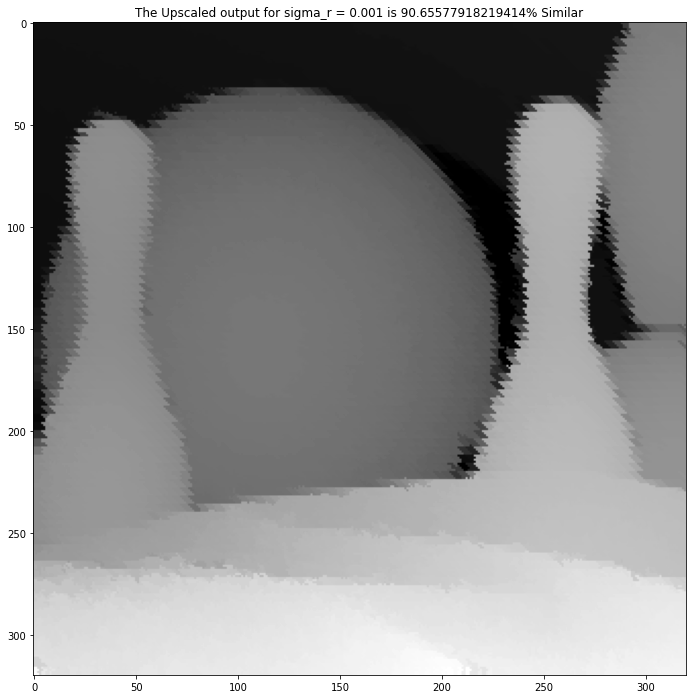

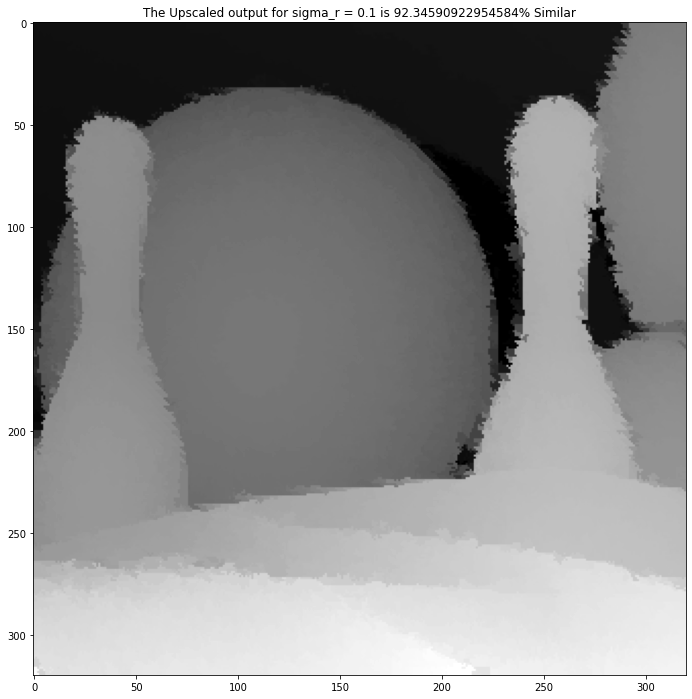

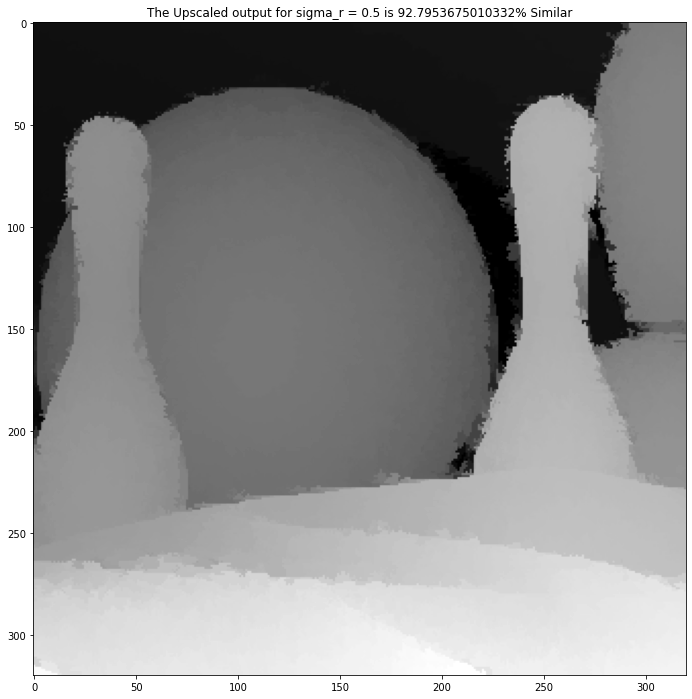

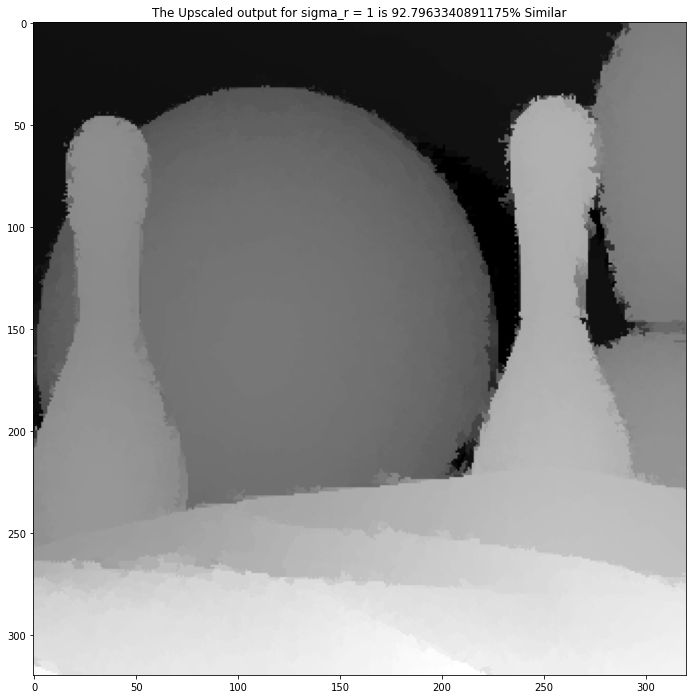

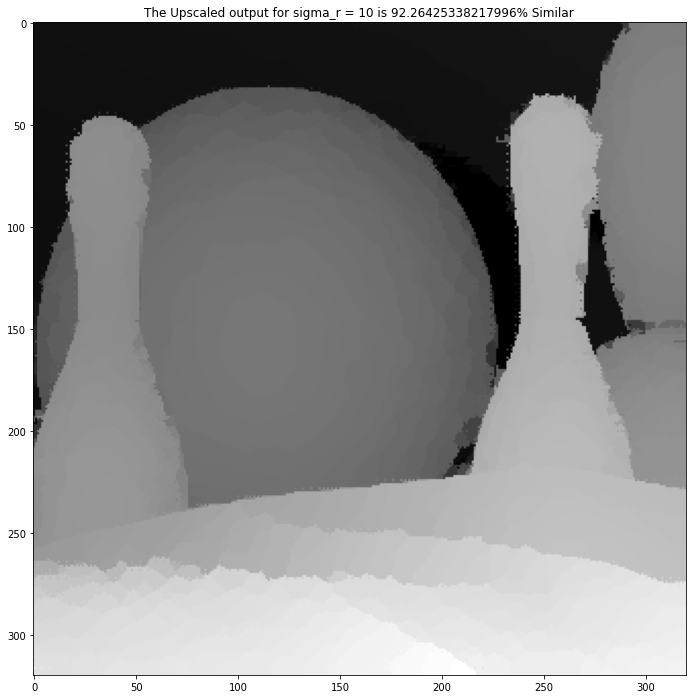

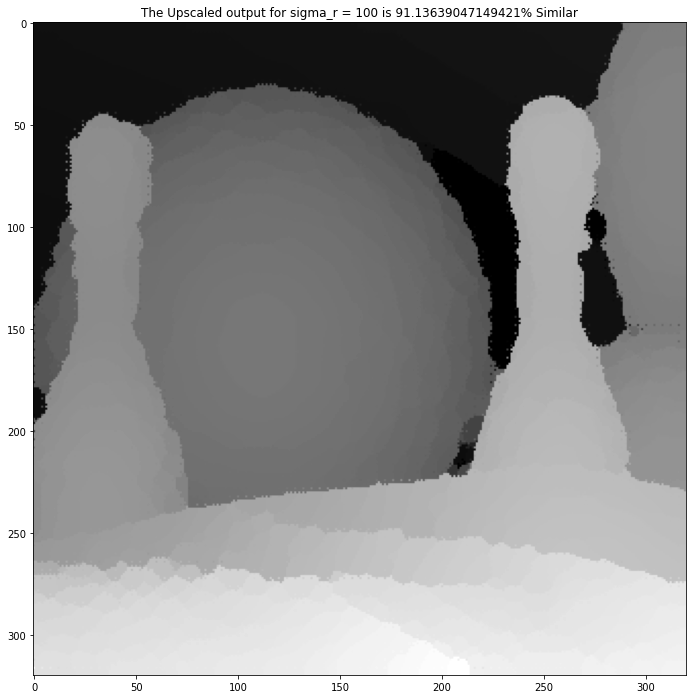

In [90]:
fig, index = plt.figure(figsize=(30, 12)), 1
rows,columns=1,3

rgb = getImg("../images/rgb/Bowling.png", 1)
ground_truth = getImg("../images/depth/Bowling_depth.png", 0)
# smol = downsample(np.copy(ground_truth), downsampling_percentange)

# print(exp)
depth = downsample(np.copy(ground_truth),100/(2**iterations))
sigmaR = [0.001, 0.1, 0.5, 1, 10, 100]

for i in range(len(sigmaR)):
    fig, index = plt.figure(figsize=(30, 12)), 1
    rows,columns=1,1
    
    output = call_back(depth,rgb, filter_size,sigma_s,sigmaR[i],iterations)
    errp = error(ground_truth, output)*100

    fig.add_subplot(rows, columns, index)
    plt.imshow(output,cmap="gray")
    plt.title("The Upscaled output for sigma_r = "+ str(sigmaR[i]) + " is " + str(errp) + "% Similar")
    index+=1
    plt.savefig('../images/SigmaR/'+'Sigmar_'+str(sigmaR[i])+'.png')

# errp = error(ground_truth, output)*100
    


# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(ground_truth,cmap="gray")
# plt.title("Ground Truth")
# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(output, cmap="gray")
# plt.title("The Upscaled output is "+ str(errp) + "% Similar")
# plt.savefig('../images/test.png')
# plt.show()
# print(error(ground_truth, output))


In [94]:
fig, index = plt.figure(figsize=(30, 12)), 1
rows,columns=1,3

rgb = getImg("../images/rgb/Bowling.png", 1)
ground_truth = getImg("../images/depth/Bowling_depth.png", 0)
# smol = downsample(np.copy(ground_truth), downsampling_percentange)

# print(exp)
depth = downsample(np.copy(ground_truth),100/(2**iterations))
sigmaS = [0.001, 0.1, 0.5, 1, 10, 100]

for i in range(len(sigmaS)):
    fig, index = plt.figure(figsize=(30, 12)), 1
    rows,columns=1,1
    
    output = call_back(depth,rgb, filter_size,sigmaS[i],sigma_r,iterations)
    errp = error(ground_truth, output)*100
    
    fig.add_subplot(rows, columns, index)
    plt.imshow(output,cmap="gray")
    plt.title("The Upscaled output for sigma_s = "+ str(sigmaS[i]) + " is " + str(errp) + "% Similar")
    index+=1
    plt.savefig('../images/SigmaS/'+'Sigmas_'+str(sigmaS[i])+'.png')

KeyboardInterrupt: 

<Figure size 2160x864 with 0 Axes>

<Figure size 2160x864 with 0 Axes>

<Figure size 2160x864 with 0 Axes>

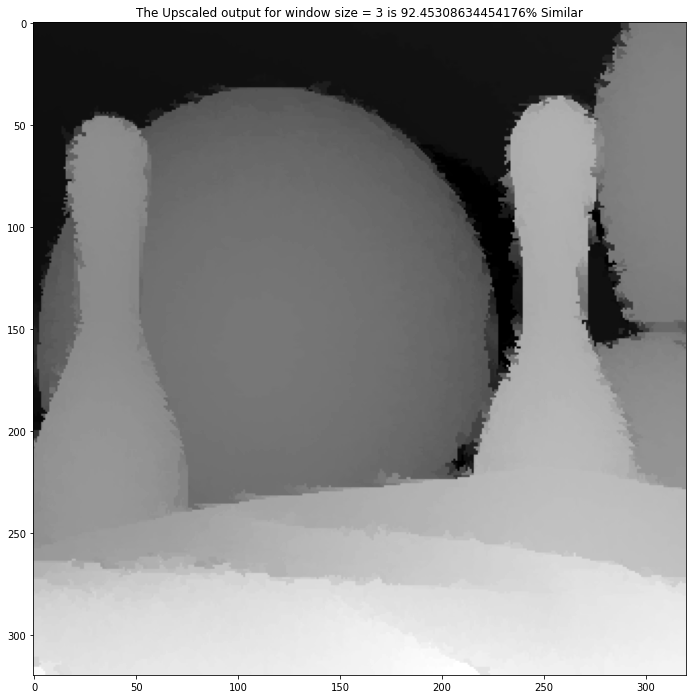

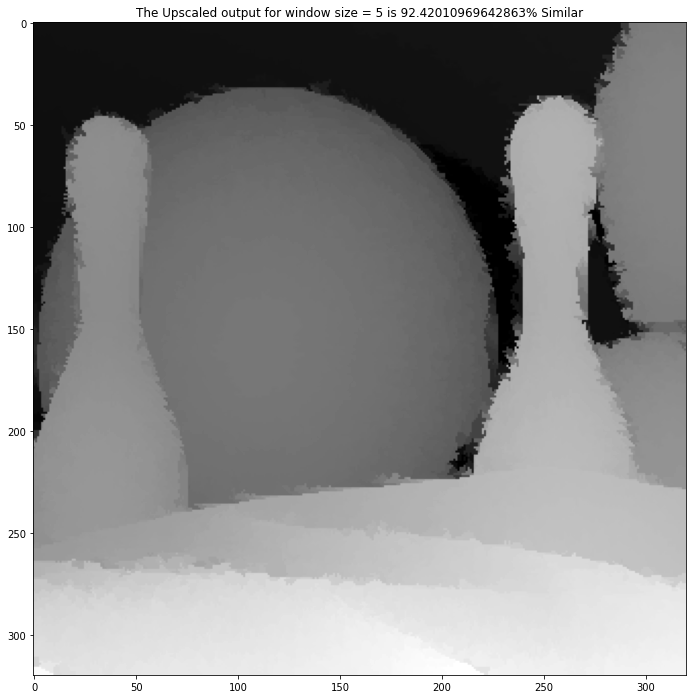

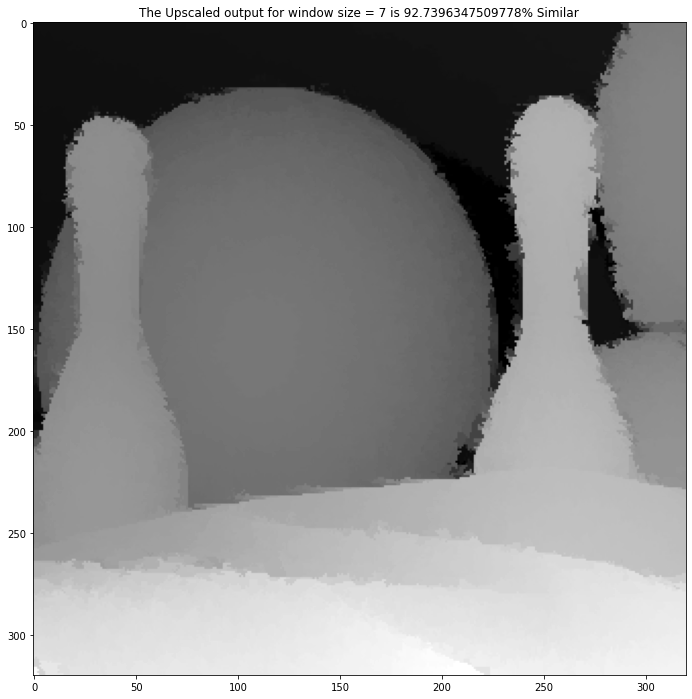

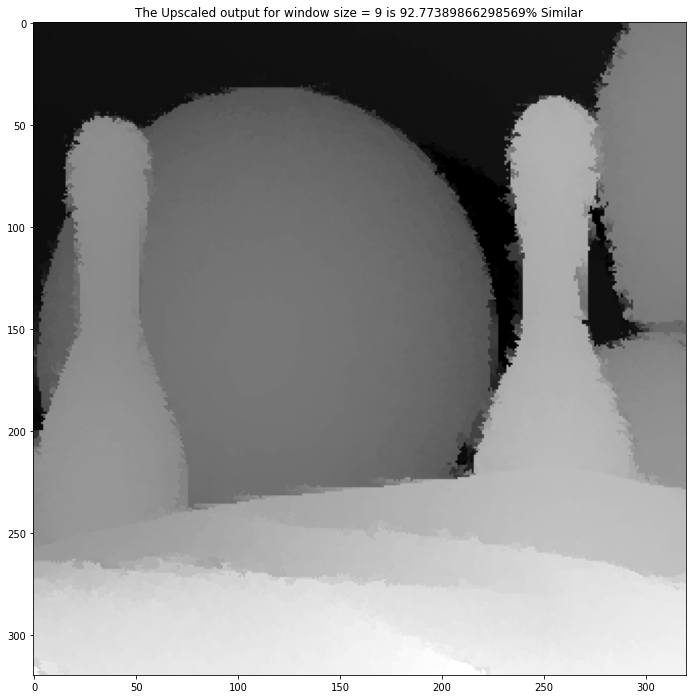

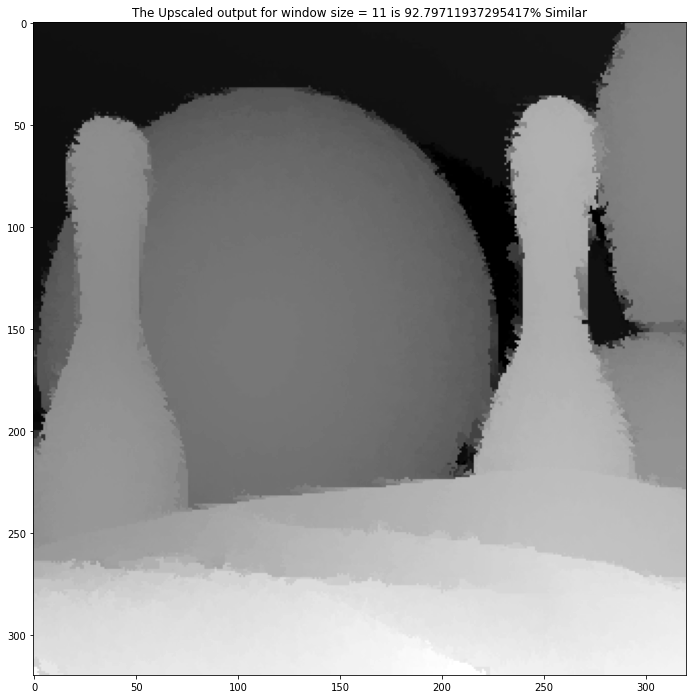

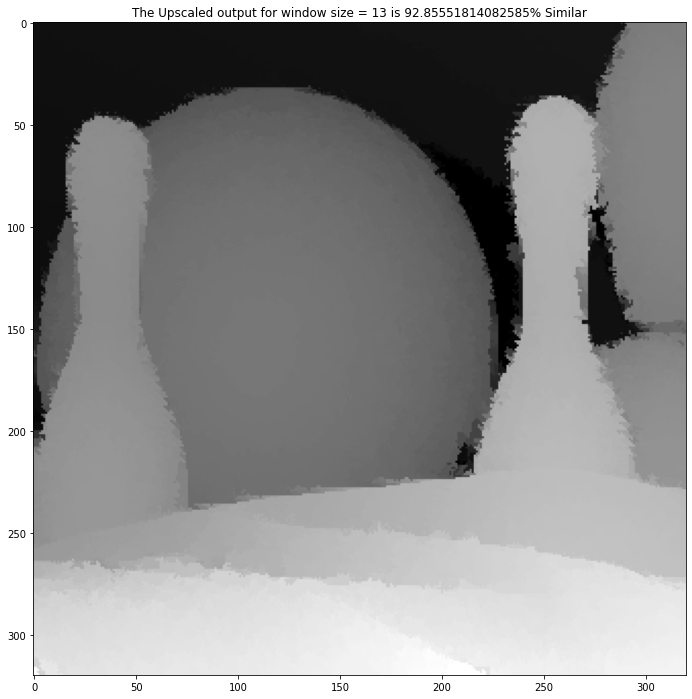

In [97]:
fig, index = plt.figure(figsize=(30, 12)), 1
rows,columns=1,3

rgb = getImg("../images/rgb/Bowling.png", 1)
ground_truth = getImg("../images/depth/Bowling_depth.png", 0)
# smol = downsample(np.copy(ground_truth), downsampling_percentange)

# print(exp)
depth = downsample(np.copy(ground_truth),100/(2**iterations))
window = [3, 5, 7, 9, 11, 13]

for i in range(len(window)):
    fig, index = plt.figure(figsize=(30, 12)), 1
    rows,columns=1,1
    
    output = call_back(depth,rgb, window[i],sigma_s,sigma_r,iterations)
    errp = error(ground_truth, output)*100
    
    fig.add_subplot(rows, columns, index)
    plt.imshow(output,cmap="gray")
    plt.title("The Upscaled output for window size = "+ str(window[i]) + " is " + str(errp) + "% Similar")
    index+=1
    plt.savefig('../images/Window_Size/'+'window_'+str(window[i])+'.png')

94.80078635289578


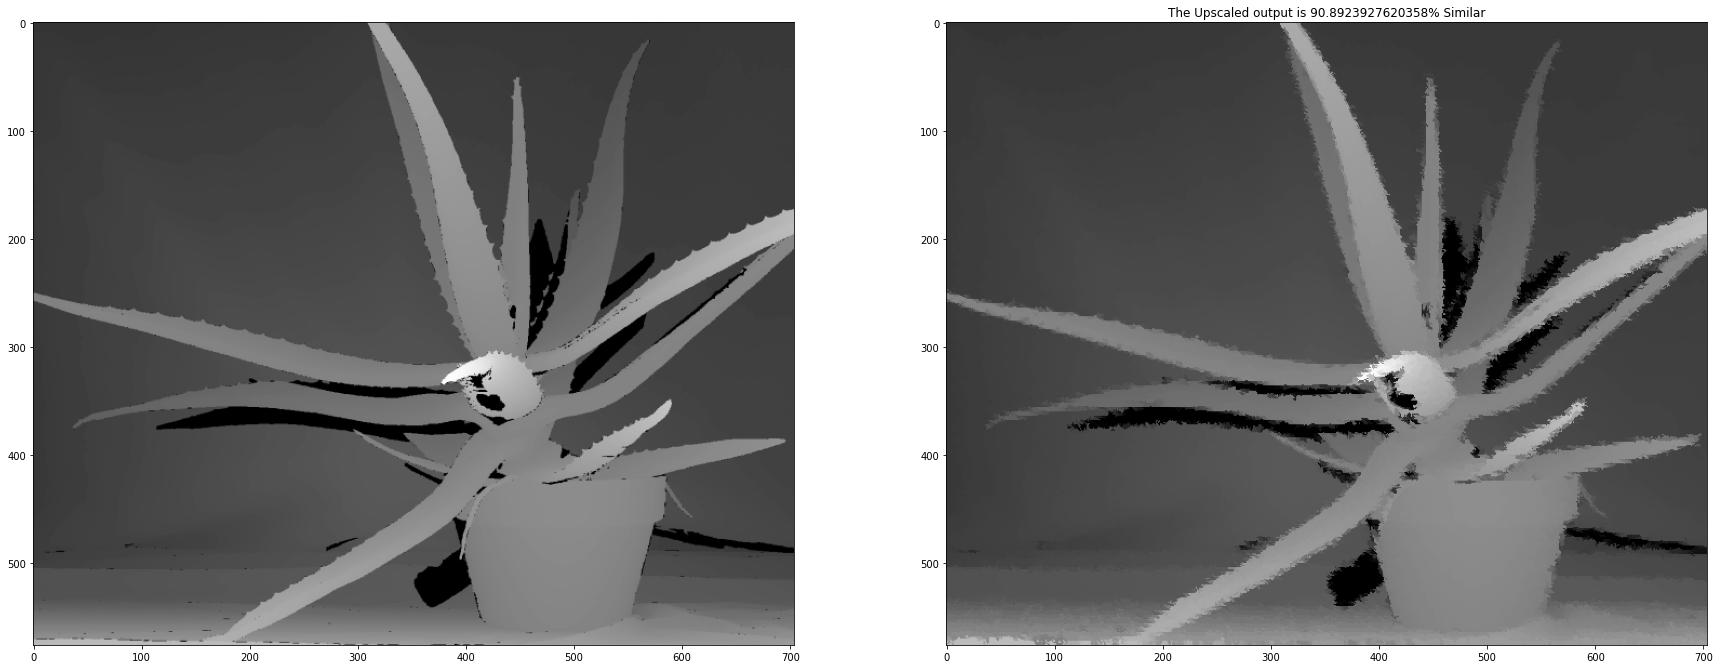

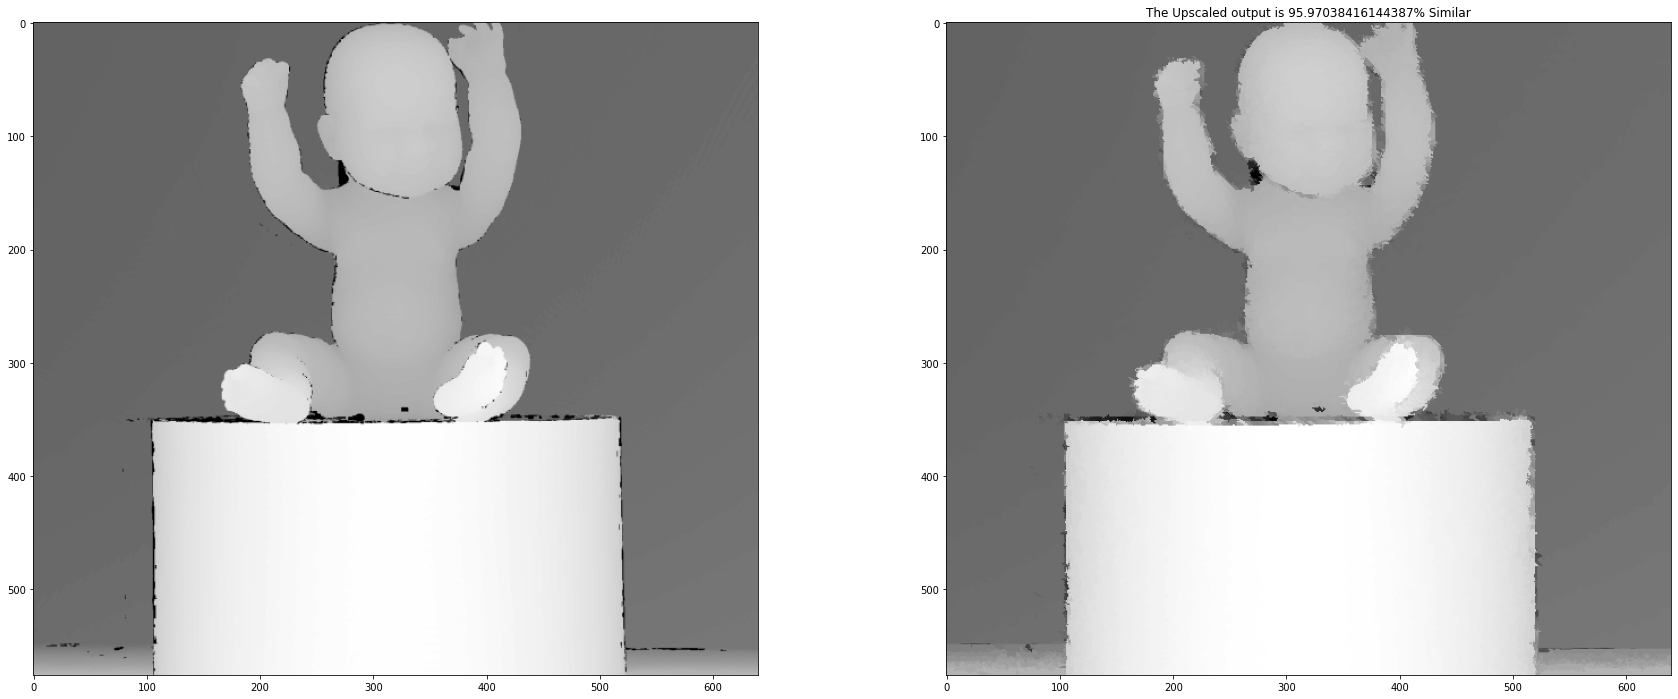

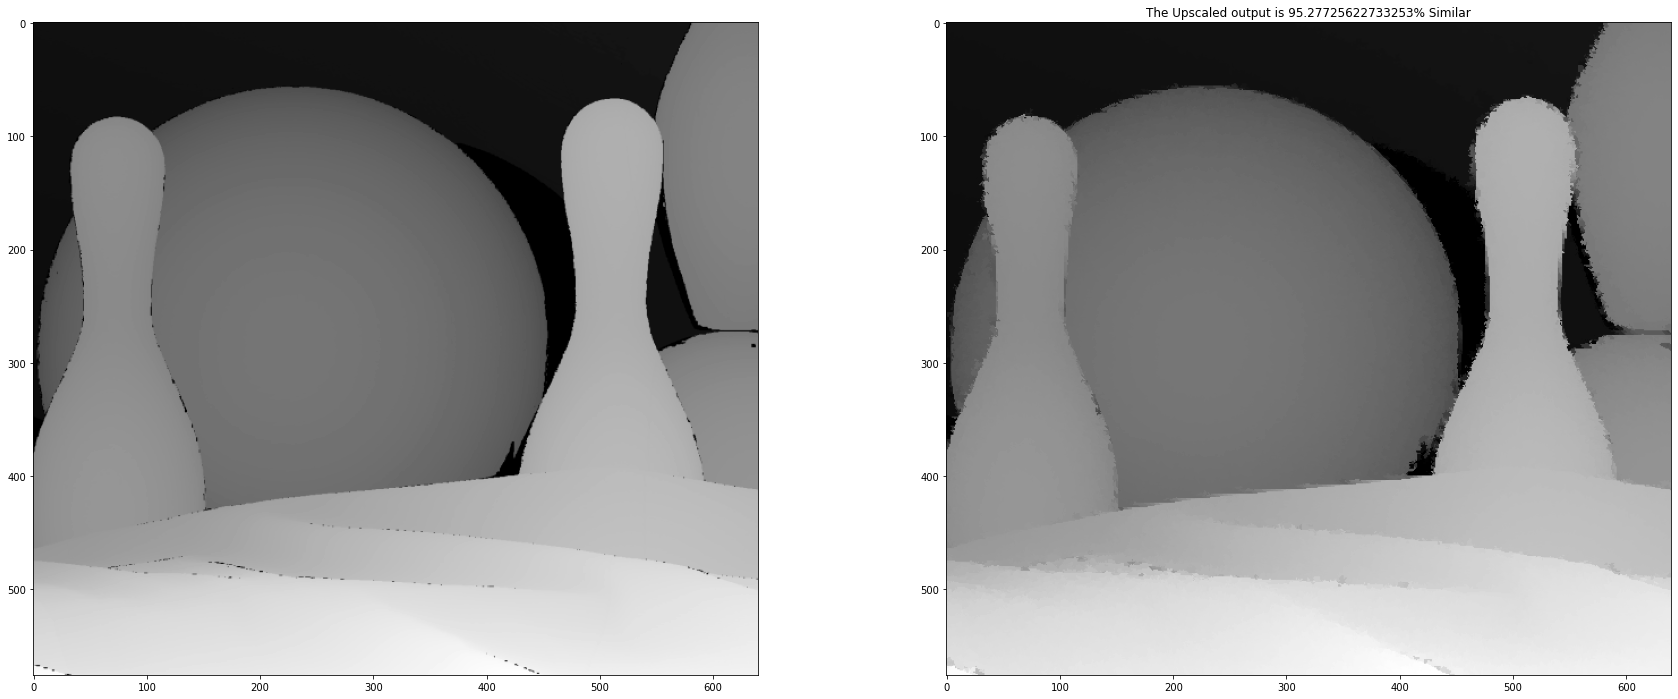

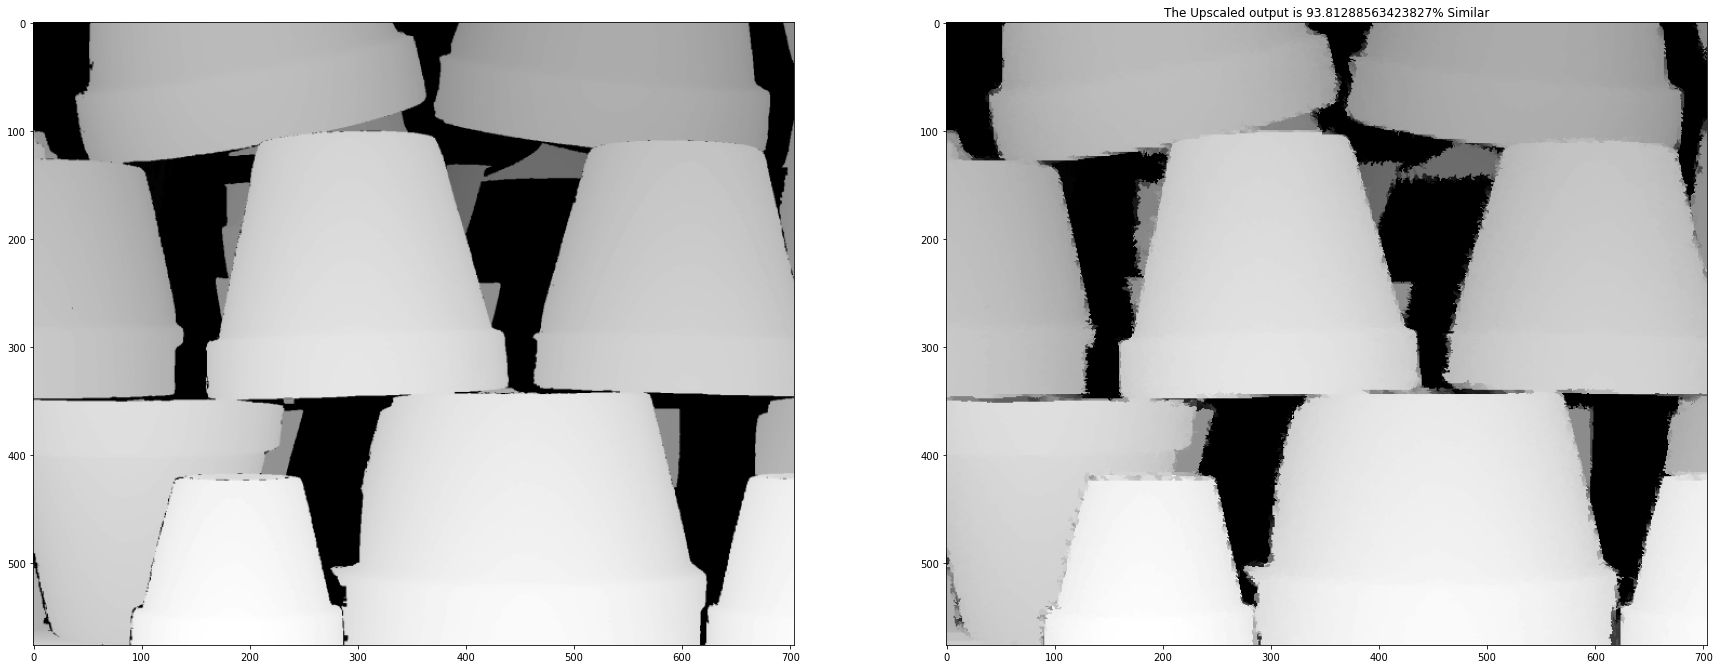

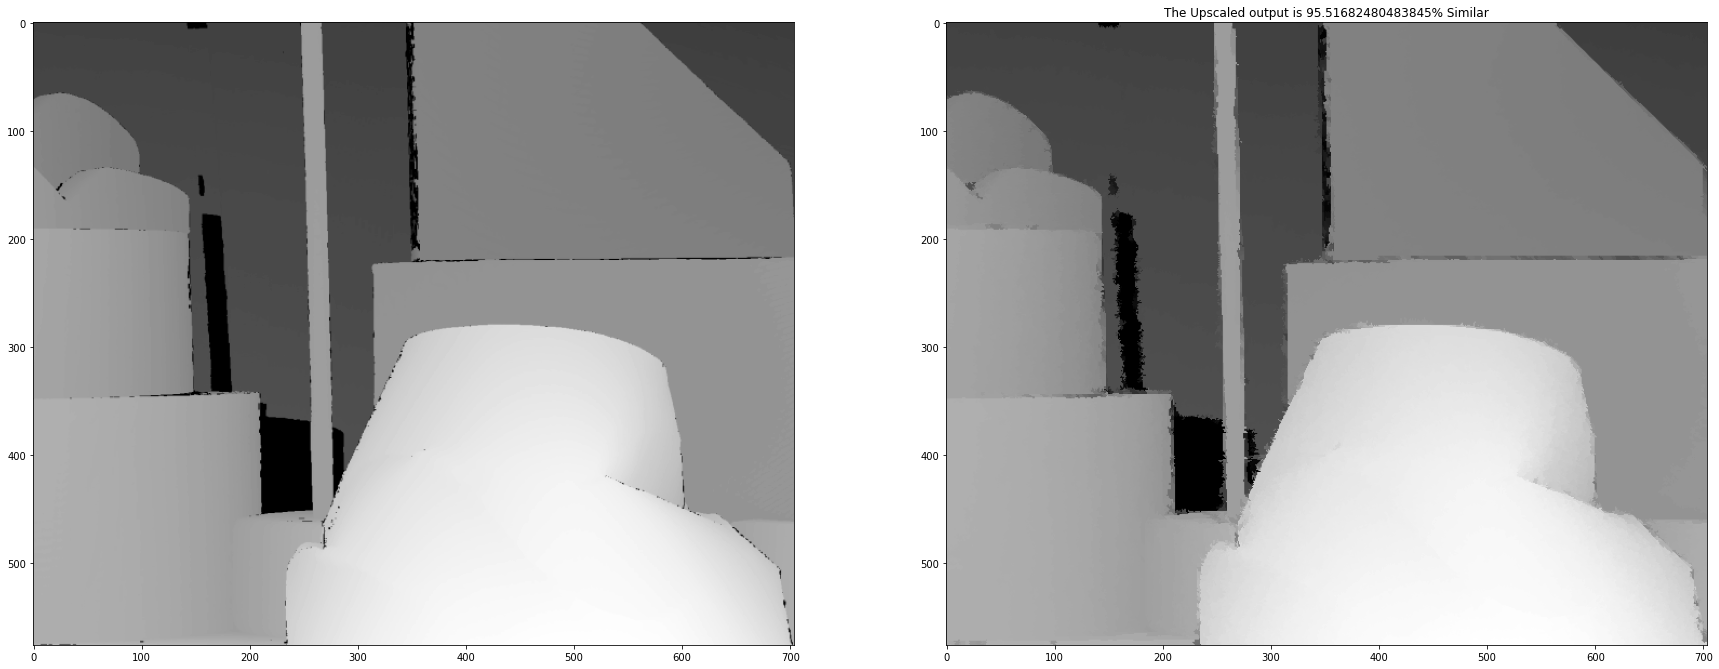

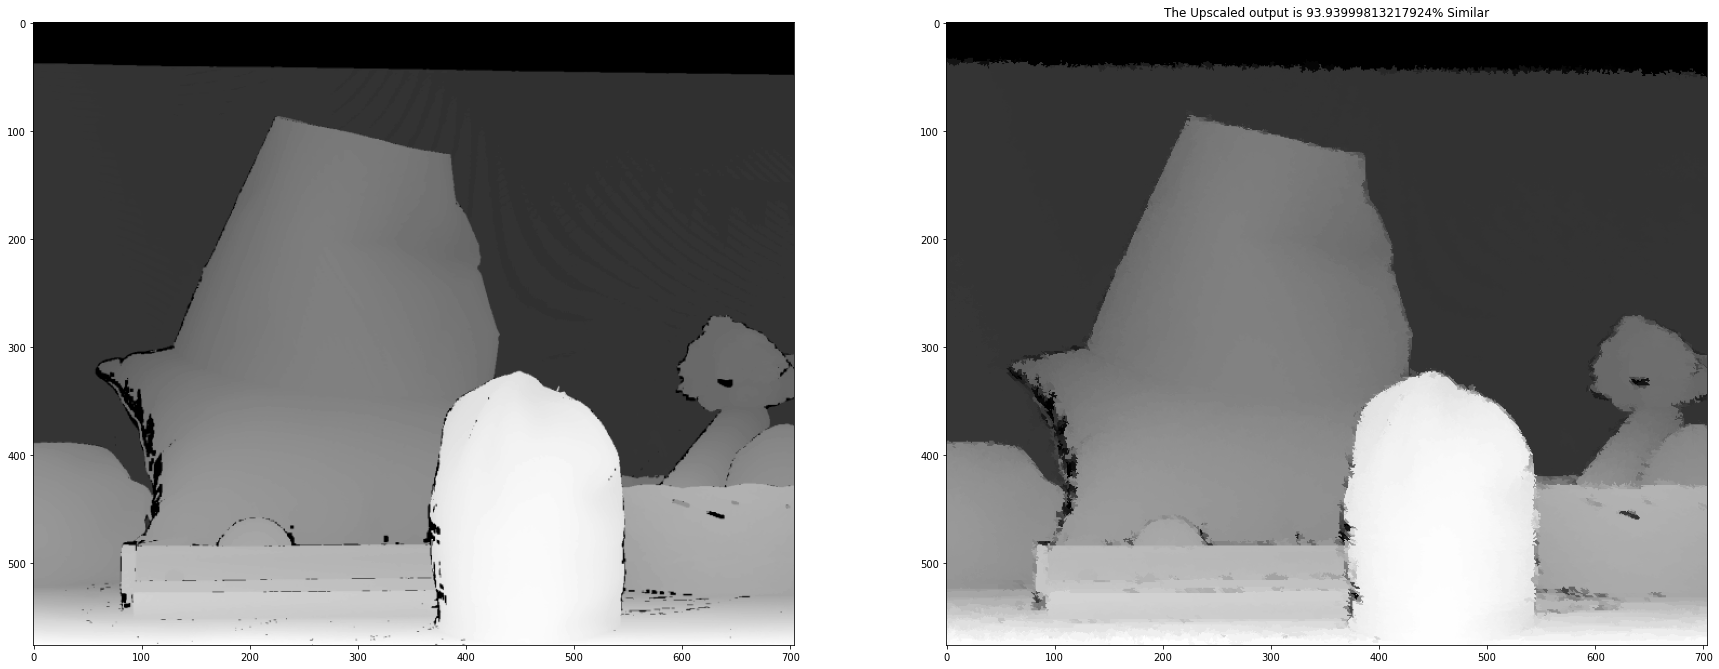

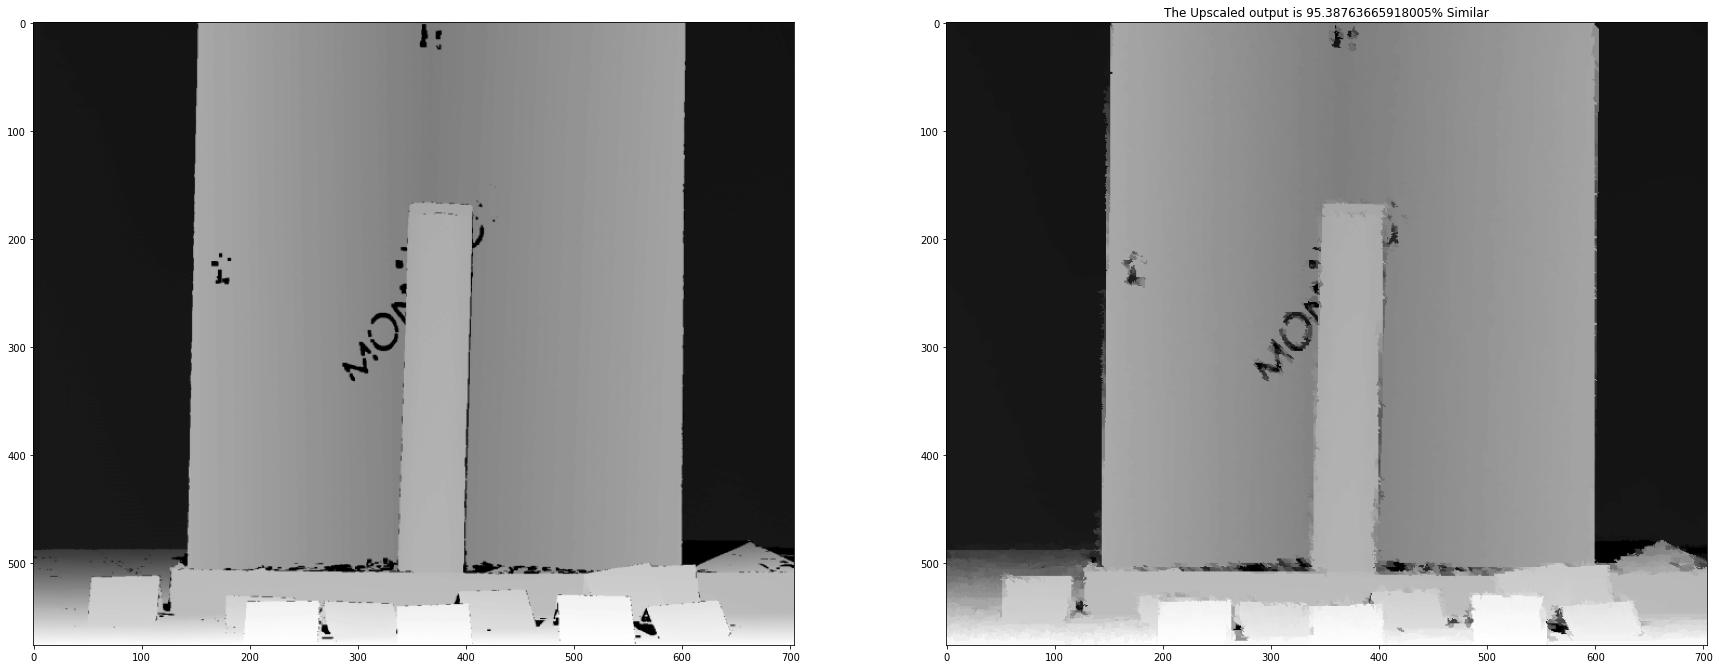

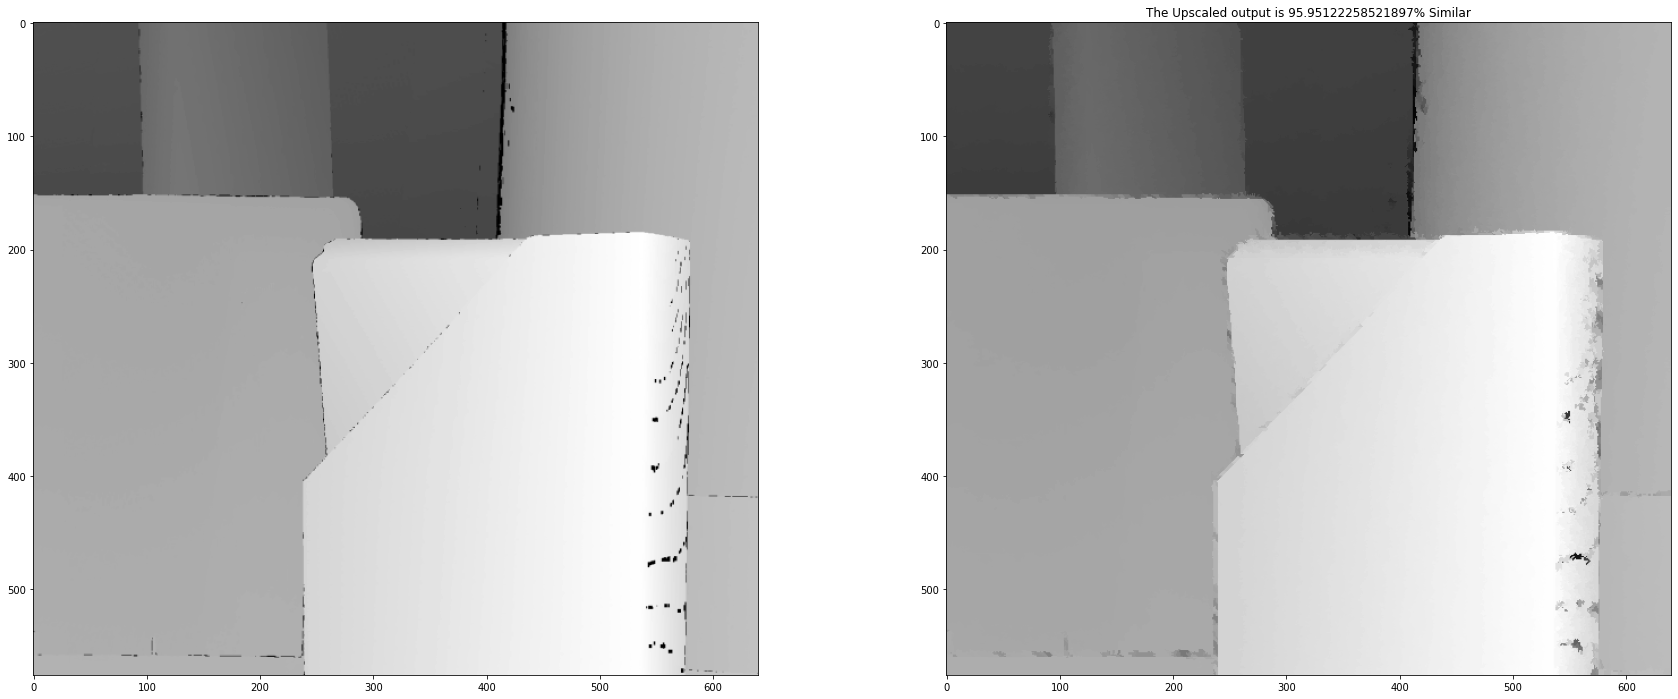

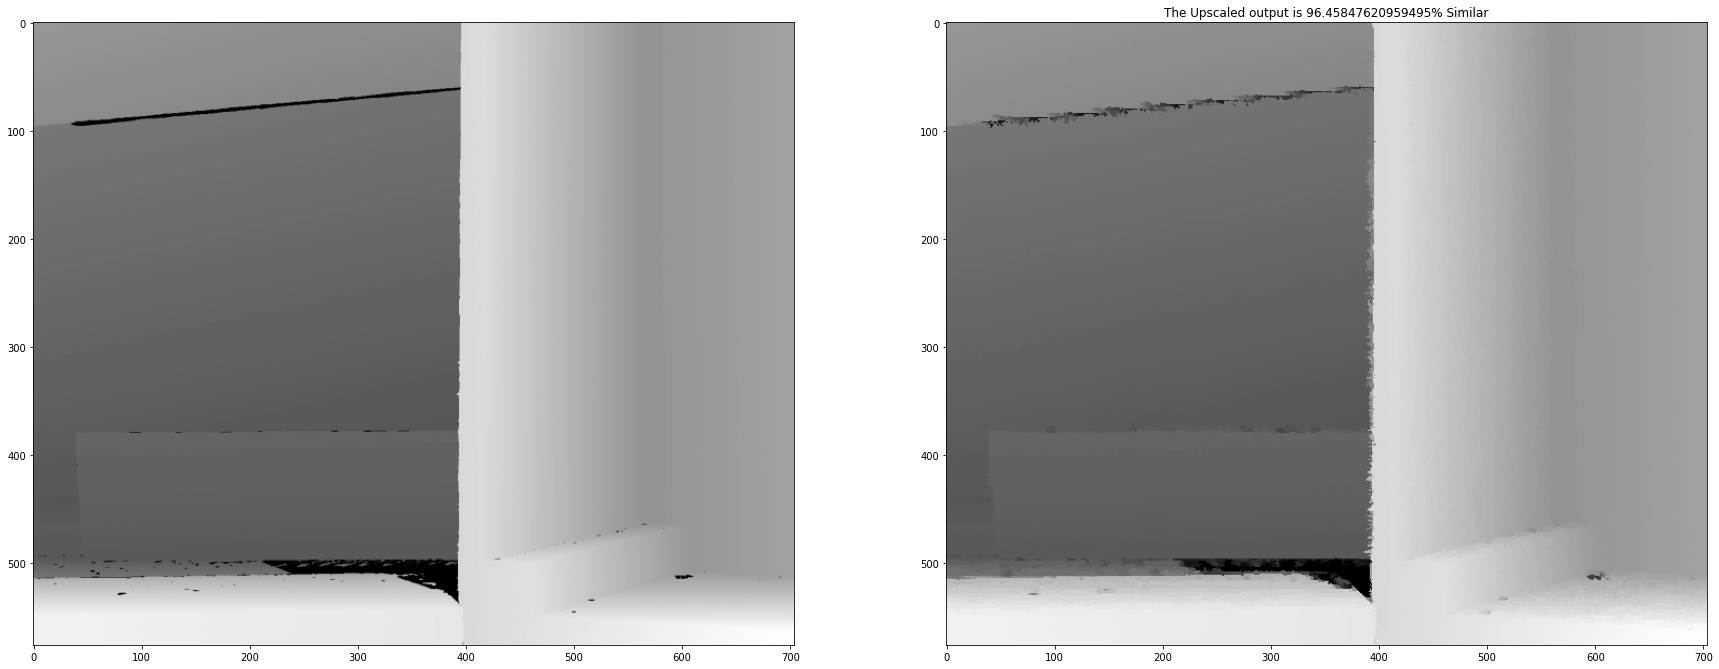

In [80]:
rgb_images =[]
depth_images=[]
for filename in os.listdir('../images/rgb'):
    rgb_images.append(filename)
for filename in os.listdir('../images/depth'):
    depth_images.append(filename)
rgb_images.sort()
depth_images.sort()

avg_error=0
for i in range(len(rgb_images)):
    fig, index = plt.figure(figsize=(30, 12)), 1
    rows,columns=1,2
    rgb = getImg("../images/rgb/"+rgb_images[i], 1)
    ground_truth = getImg("../images/depth/"+depth_images[i], 0)
    
    depth = downsample(np.copy(ground_truth),100/(2**iterations))
    output = call_back(depth,rgb, filter_size,sigma_s,sigma_r,iterations)
    errp = error(ground_truth, output)*100
    
    fig.add_subplot(rows, columns, index)
    plt.imshow(ground_truth,cmap="gray")
    index+=1
    fig.add_subplot(rows, columns, index)
    plt.imshow(output,cmap="gray")
    plt.title("The Upscaled output is "+ str(errp) + "% Similar")
    index+=1
    plt.savefig('../images/Algorithm_output/'+'output_'+rgb_images[i])
    avg_error+=errp

    
avg_error = avg_error/(len(rgb_images))
print(avg_error)

In [ ]:
rgb_images =[]
depth_images=[]
for filename in os.listdir('../images/rgb1'):
    rgb_images.append(filename)
for filename in os.listdir('../images/depth1'):
    depth_images.append(filename)
rgb_images.sort()
depth_images.sort()

avg_error=0
for i in range(len(rgb_images)):
    fig, index = plt.figure(figsize=(30, 12)), 1
    rows,columns=1,2
    rgb = getImg("../images/rgb1/"+rgb_images[i], 1)
    ground_truth = getImg("../images/depth1/"+depth_images[i], 0)
    
    depth = downsample(np.copy(ground_truth),100/(2**iterations))
    output = call_back(depth,rgb, filter_size,sigma_s,sigma_r,iterations)
    errp = error(ground_truth, output)*100
    
    fig.add_subplot(rows, columns, index)
    plt.imshow(ground_truth,cmap="gray")
    index+=1
    fig.add_subplot(rows, columns, index)
    plt.imshow(output,cmap="gray")
    plt.title("The Upscaled output is "+ str(errp) + "% Similar")
    index+=1
    plt.savefig('../images/Algorithm_output1/'+'output_'+rgb_images[i])
    avg_error+=errp

    
avg_error = avg_error/(len(rgb_images))
print(avg_error)

In [55]:
#testing functions

# fig, index = plt.figure(figsize=(30, 12)), 1
# rows,columns=1,3

# rgb = getImg("../images/aloe.png", 1)
# ground_truth = getImg("../images/aloedepth.png", 0)
# # depthimg = gen_depth_image(imgL, imgR)

# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(rgb)
# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(ground_truth, cmap="gray")

# print(rgb.shape)
# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(depthimg, cmap="gray")

In [56]:
#testing functions

# fig, index = plt.figure(figsize=(30, 12)), 1
# rows,columns=1,3

# smol = downsample(np.copy(ground_truth), downsampling_percentange)
# print(smol.shape)
# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(smol, cmap="gray")

# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(ground_truth, cmap="gray")

In [57]:
# #testing functions

# fig, index = plt.figure(figsize=(30, 12)), 1
# rows,columns=1,3

# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(smol, cmap="gray")
# stepped = stepUp(np.copy(smol))
# # print(stepped.shape)
# print(type(smol), type(stepped))

# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(stepped, cmap="gray")

In [58]:
# # boi = np.array([[1,2,3],[4,5,6],[5,8,11]])
# norm = genGuidanceImg(np.copy(rgb), np.copy(stepped))
# # print(rgb.shape)

# lam = genLambda(np.copy(norm))
# print(lam)

# fig, index = plt.figure(figsize=(30, 12)), 1
# rows,columns=1,3

# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(norm, cmap="gray")

# # print(boi)
# # print(lam)

In [59]:
# fig, index = plt.figure(figsize=(30, 12)), 1
# rows,columns=1,3

# print(norm.shape, stepped.shape)

# med = stepped

# intermediate = call_back(smol, rgb, filter_size, sigma_s, sigma_r, iterations)
# # med = cv2.medianBlur(intermediate, 8)

# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(smol, cmap="gray")

# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(ground_truth, cmap="gray")

# # intermediate[1][1] = 255

# fig.add_subplot(rows, columns, index)
# index += 1
# plt.imshow(intermediate, cmap="gray")

# # print(intermediate.shape)


In [60]:
# fig, index = plt.figure(figsize=(30, 12)), 1
# rows,columns=1,3
# resized_image = cv2.resize(smol, (ground_truth.shape[1],ground_truth.shape[0]), interpolation = cv2.INTER_AREA)

# fig.add_subplot(rows, columns, index)
# plt.imshow(resized_image,cmap='gray')
# index+=1
# fig.add_subplot(rows, columns, index)
# plt.imshow(intermediate,cmap='gray')

In [61]:
# depth, rgb, k, sigS, sigR, levels = 
